<a href="https://colab.research.google.com/github/bryaanabraham/Wandering_Guardian/blob/main/ML%20Implementation/ML_Navigation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [661]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import folium
import random
from geopy.distance import geodesic

In [662]:
coords = pd.read_csv("training_dataset.csv")
coords = coords.dropna(how='all')
coords.head()

,longitude,latitude,path_id
0,12.821062,80.044729,1.0
1,12.821219,80.044743,1.0
2,12.821479,80.044736,1.0
3,12.821561,80.044743,1.0
4,12.821636,80.044743,1.0


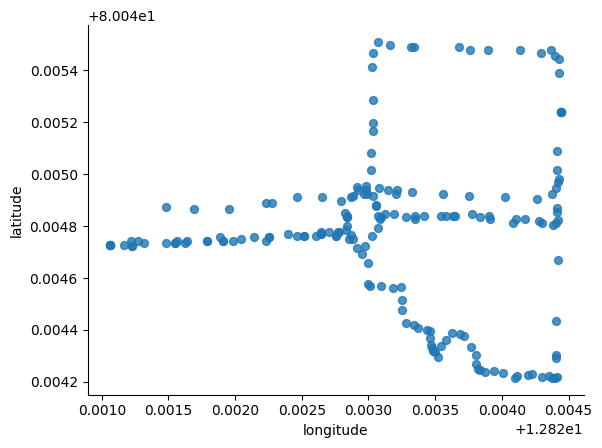

In [663]:
coords.plot(kind='scatter', x='longitude', y='latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [664]:
path = []
for i in range(1,len(coords['path_id'].unique())):
    path.append(coords[coords['path_id'] == i])

<ipython-input-665-c10d95fd9eae>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


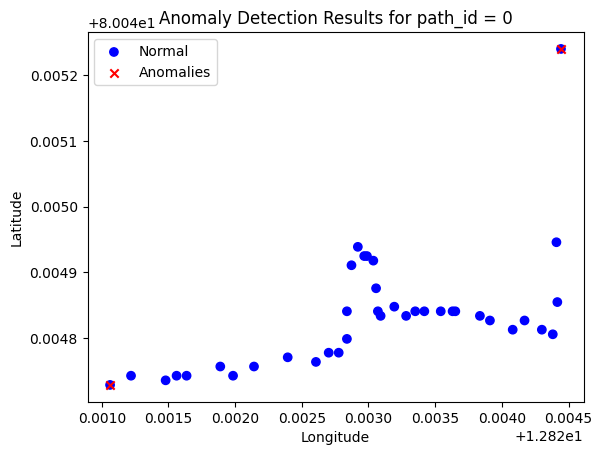

Anomalies detected in navigation path.


<ipython-input-665-c10d95fd9eae>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


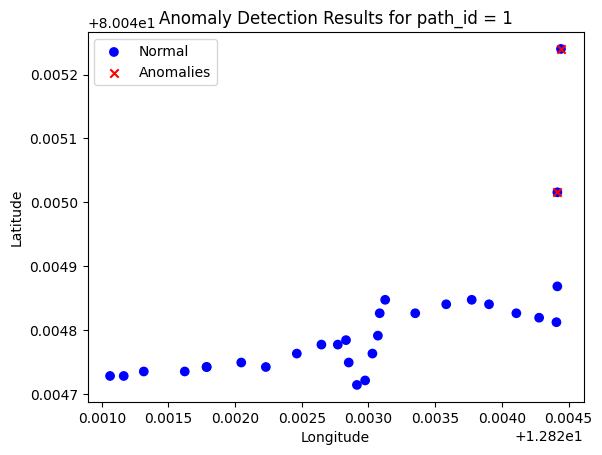

Anomalies detected in navigation path.


<ipython-input-665-c10d95fd9eae>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


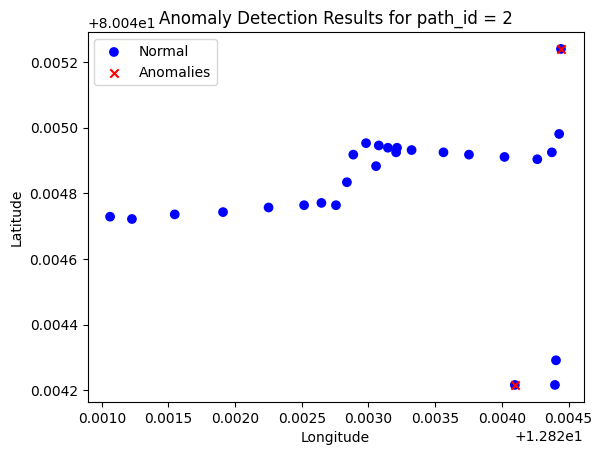

Anomalies detected in navigation path.


<ipython-input-665-c10d95fd9eae>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


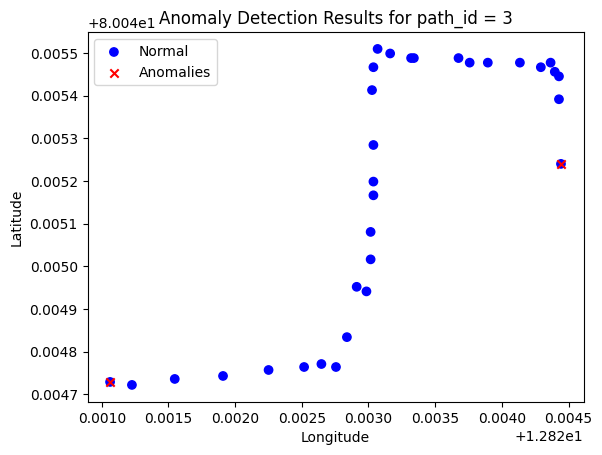

Anomalies detected in navigation path.


In [665]:
from sklearn.ensemble import IsolationForest

n = len(coords['path_id'].unique()) - 1

for i in range(n):
    data = np.vstack((path[i]['longitude'], path[i]['latitude'])).T

    labels = np.array([0] * len(path[i]))

    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(data)

    predictions = model.predict(data)
    anomaly_indices = np.where(predictions == -1)[0]

    colors = np.where(labels == 0, 'blue', 'red')

    plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')
    plt.scatter(data[anomaly_indices, 0], data[anomaly_indices, 1], color='red', marker='x', label='Anomalies')
    plt.legend()
    plt.title(f"Anomaly Detection Results for path_id = {i}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    if len(anomaly_indices) > 0:
        print("Anomalies detected in navigation path.")
        # Filter out anomalies from dataframe
        path[i] = path[i][~path[i].index.isin(anomaly_indices)]
        # Reset index after filtering
        path[i] = path[i].reset_index(drop=True)
    else:
        print("No anomalies detected in navigation path.")


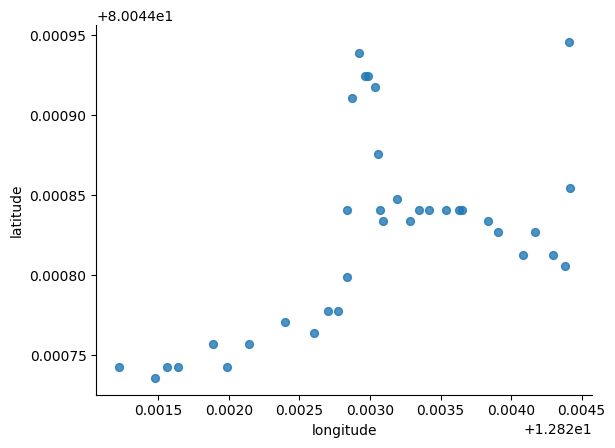

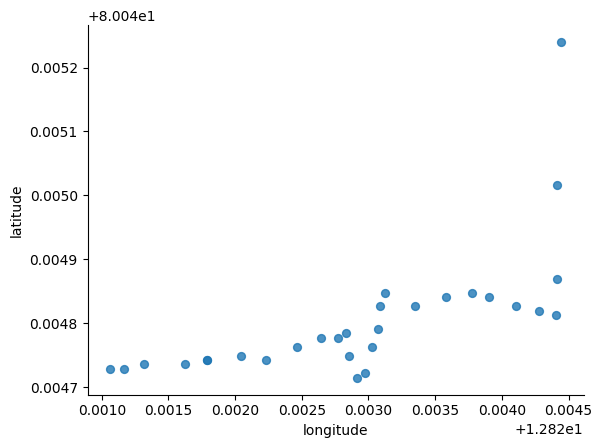

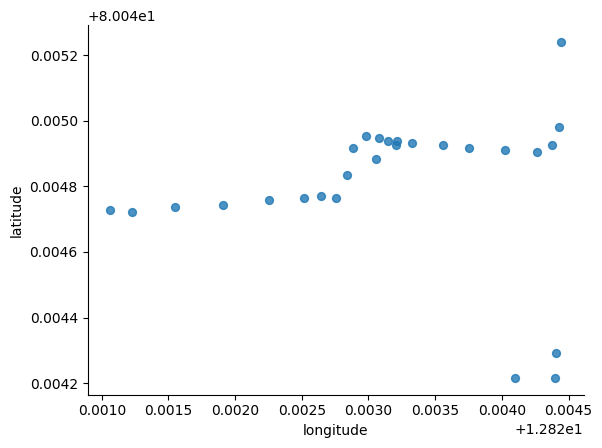

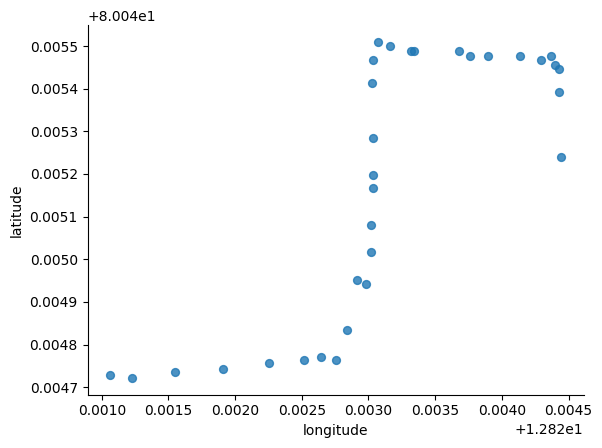

In [666]:
# data after outlier pruning
n = len(coords['path_id'].unique())-1
for i in range(n):
   path[i].plot(kind='scatter', x='longitude', y='latitude', s=32, alpha=.8)
   plt.gca().spines[['top', 'right',]].set_visible(False)

In [667]:
path[0].head()

,longitude,latitude,path_id
0,12.821219,80.044743,1.0
1,12.821479,80.044736,1.0
2,12.821561,80.044743,1.0
3,12.821636,80.044743,1.0
4,12.821889,80.044757,1.0


In [668]:
# Deviation parameters
min_deviation_distance = -0.00004
max_deviation_distance = 0.00004
# deviation is set to zero for now so elevation remains constant
max_deviation_angle = 0

# Generate random deviation distances and angles for each point in the DataFrame
num_points = len(coords)
random_deviation_distances = np.random.uniform(min_deviation_distance, max_deviation_distance, num_points)
random_deviation_angles = np.random.uniform(0, max_deviation_angle, num_points)

# Convert random angles to radians
random_deviation_angles_radians = np.radians(random_deviation_angles)

# Calculate deviation in latitude and longitudet
deviation_distance_lat = random_deviation_distances * np.cos(random_deviation_angles_radians)
deviation_distance_lon = random_deviation_distances * np.sin(random_deviation_angles_radians)

decoy_coords = coords.copy()
decoy_coords['latitude'] += deviation_distance_lat
decoy_coords['longitude'] += deviation_distance_lon

decoy_coords.head()

,longitude,latitude,path_id
0,12.821062,80.044718,1.0
1,12.821219,80.044776,1.0
2,12.821479,80.044742,1.0
3,12.821561,80.044746,1.0
4,12.821636,80.044724,1.0


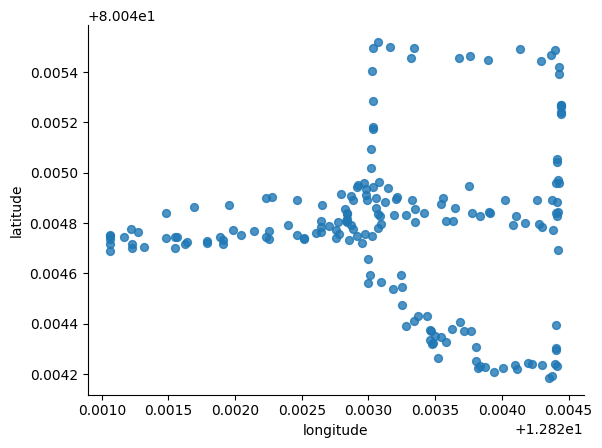

In [669]:
decoy_coords.plot(kind='scatter', x='longitude', y='latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [670]:
decoy_path = []
for i in range(1, len(decoy_coords['path_id'].unique())):
    decoy_path.append(decoy_coords[decoy_coords['path_id'] == i])

decoy_path[0].head()

,longitude,latitude,path_id
0,12.821062,80.044718,1.0
1,12.821219,80.044776,1.0
2,12.821479,80.044742,1.0
3,12.821561,80.044746,1.0
4,12.821636,80.044724,1.0


In [671]:
maps = []

max_lat = max(coords['longitude'])
min_lat = min(coords['longitude'])
min_lon = min(coords['latitude'])
max_lon = max(coords['latitude'])

n = len(coords['path_id'].unique())-1

# each path_id has its own map
for i in range(0,n):

  m = folium.Map()
  gps_path = list(zip(path[i]['longitude'], path[i]['latitude']))
  folium.PolyLine(locations=gps_path, color='blue', weight=2.5, opacity=0.8).add_to(m)
  folium.Marker(gps_path[20], icon=folium.Icon(color='blue'), popup=f'Safe Path').add_to(m)

  gps_decoy_path = list(zip(decoy_path[i]['longitude'], decoy_path[i]['latitude']))
  folium.PolyLine(locations=gps_decoy_path, color='red', weight=2.5, opacity=0.8).add_to(m)
  folium.Marker(gps_decoy_path[10], icon=folium.Icon(color='red'), popup=f'Decoy Path').add_to(m)

  m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
  maps.append(m)

  display(maps[i])


In [672]:
def distance(current_point, path):
  nearest_point_on_line = min(path, key=lambda point: geodesic(point, current_point).meters)
  return geodesic(current_point, nearest_point_on_line).meters

In [673]:
def assign_color(distance):
  if distance < 2:
      return 'green'
  elif distance >= 4:
      return 'red'
  else:
      return 'orange'

In [674]:
maps = []

max_lat = max(coords['longitude'])
min_lat = min(coords['longitude'])
min_lon = min(coords['latitude'])
max_lon = max(coords['latitude'])

n = len(coords['path_id'].unique())-1

for i in range(n):
    m = folium.Map()
    gps_path = list(zip(path[i]['longitude'], path[i]['latitude']))
    folium.PolyLine(locations=gps_path, color='blue', weight=2.5, opacity=0.8).add_to(m)

    gps_decoy_path = list(zip(decoy_path[i]['longitude'], decoy_path[i]['latitude']))
    folium.PolyLine(locations=gps_decoy_path, color='red', weight=2.5, opacity=0.8).add_to(m)

    for index, row in decoy_path[i].iloc[::3].iterrows():
        current_point = (row['longitude'], row['latitude'])
        perp_dist = distance(current_point, gps_path)
        color = assign_color(perp_dist)
        folium.Marker(location=current_point,
                      popup=f"Deviation: {perp_dist:.2f} m",
                      icon=folium.Icon(color=color)).add_to(m)

    m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
    maps.append(m)

for map_obj in maps:
    display(map_obj)

In [675]:
testing_coords = pd.read_csv("testing_dataset.csv")
testing_coords = coords.dropna(how='all')
testing_coords.head()

,longitude,latitude,path_id
0,12.821062,80.044729,1.0
1,12.821219,80.044743,1.0
2,12.821479,80.044736,1.0
3,12.821561,80.044743,1.0
4,12.821636,80.044743,1.0


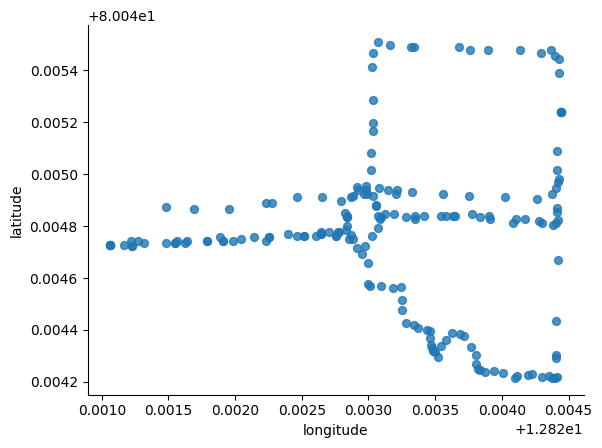

In [676]:
testing_coords.plot(kind='scatter', x='longitude', y='latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [677]:
testing_path = []
for i in range(1, len(testing_coords['path_id'].unique())):
    testing_path.append(testing_coords[testing_coords['path_id'] == i])
testing_path[0].head()

,longitude,latitude,path_id
0,12.821062,80.044729,1.0
1,12.821219,80.044743,1.0
2,12.821479,80.044736,1.0
3,12.821561,80.044743,1.0
4,12.821636,80.044743,1.0


<ipython-input-678-e6d139d921db>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


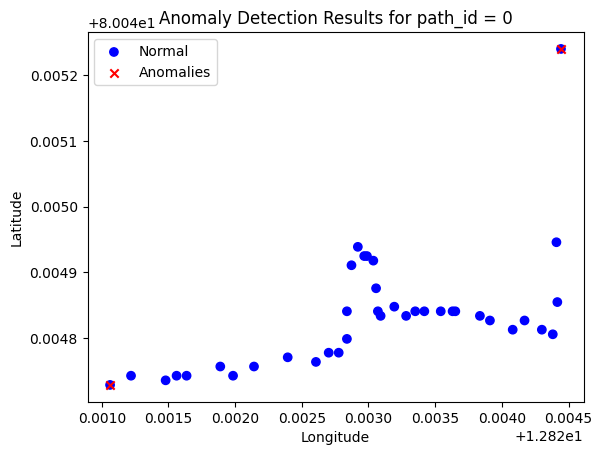

Anomalies detected in navigation path.


<ipython-input-678-e6d139d921db>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


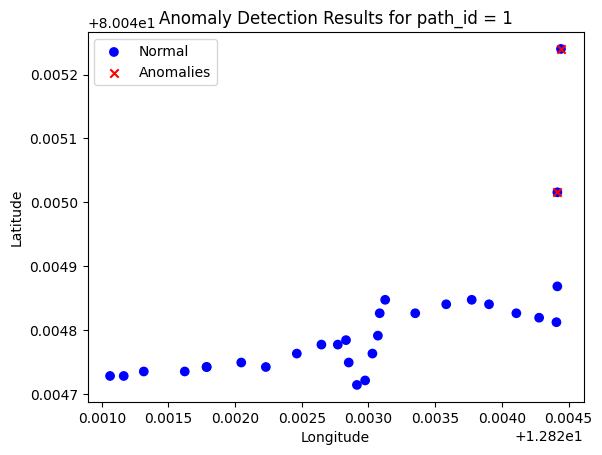

Anomalies detected in navigation path.


<ipython-input-678-e6d139d921db>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


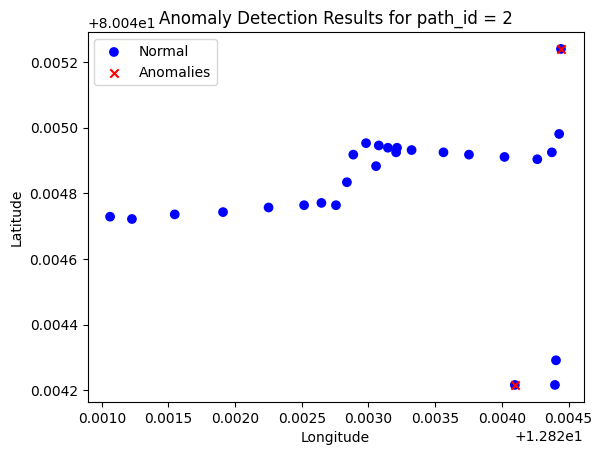

Anomalies detected in navigation path.


<ipython-input-678-e6d139d921db>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')


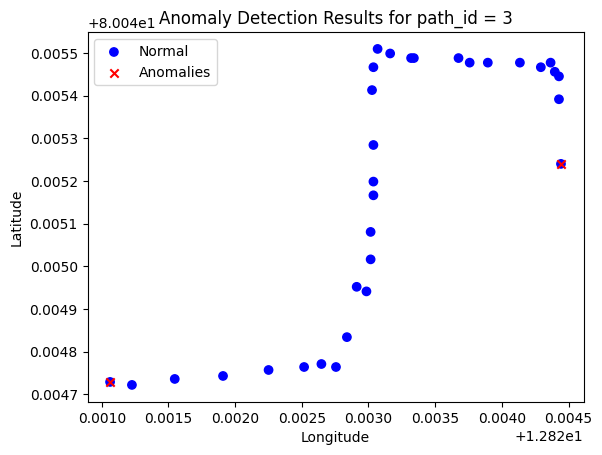

Anomalies detected in navigation path.


In [678]:
from sklearn.ensemble import IsolationForest

n = len(testing_coords['path_id'].unique()) - 1

for i in range(n):
    data = np.vstack((testing_path[i]['longitude'], testing_path[i]['latitude'])).T

    labels = np.array([0] * len(testing_path[i]))

    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(data)

    predictions = model.predict(data)
    anomaly_indices = np.where(predictions == -1)[0]

    colors = np.where(labels == 0, 'blue', 'red')

    plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='coolwarm', marker='o', label='Normal')
    plt.scatter(data[anomaly_indices, 0], data[anomaly_indices, 1], color='red', marker='x', label='Anomalies')
    plt.legend()
    plt.title(f"Anomaly Detection Results for path_id = {i}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    if len(anomaly_indices) > 0:
        print("Anomalies detected in navigation path.")
        # Filter out anomalies from dataframe
        testing_path[i] = testing_path[i][~testing_path[i].index.isin(anomaly_indices)]
        # Reset index after filtering
        testing_path[i] = testing_path[i].reset_index(drop=True)
    else:
        print("No anomalies detected in navigation path.")


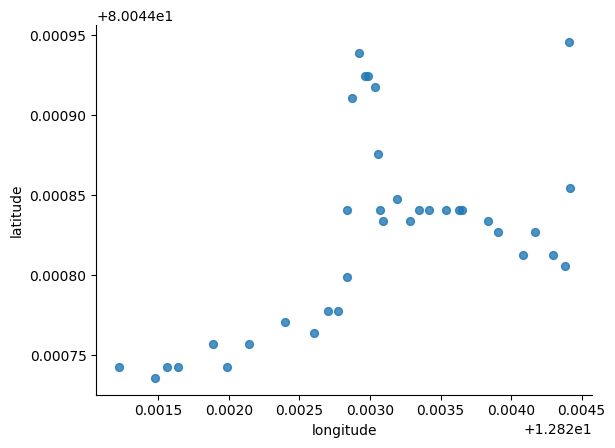

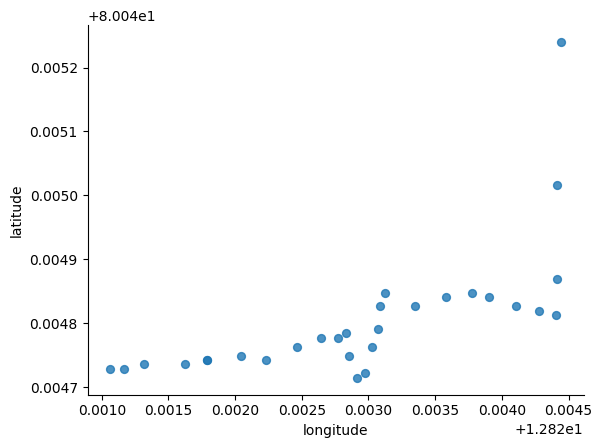

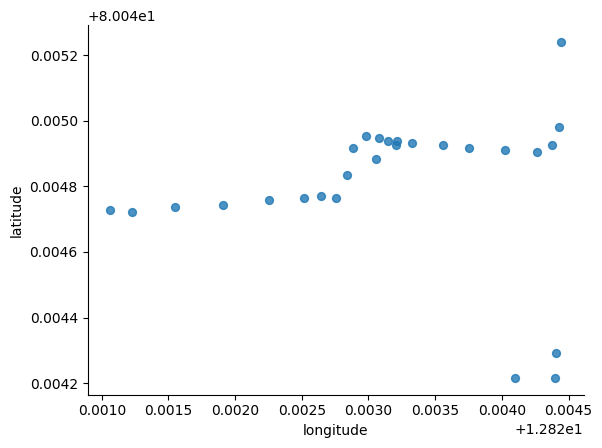

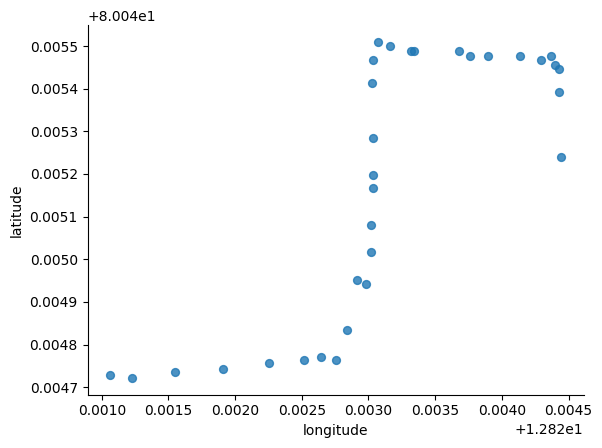

In [679]:
# data after outlier pruning
n = len(testing_coords['path_id'].unique())-1
for i in range(n):
   testing_path[i].plot(kind='scatter', x='longitude', y='latitude', s=32, alpha=.8)
   plt.gca().spines[['top', 'right',]].set_visible(False)

In [680]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from statistics import mode

In [681]:
X = coords.drop(columns=['path_id'])
y = coords['path_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

n = len(testing_coords['path_id'].unique())-1

for i in range(n):
  new_X = testing_path[i].drop(columns=['path_id'])
  predicted_path_ids = model.predict(new_X)

  print(f"Predicted Paths IDs for path '{i+1}':", end=": ")
  for path_id in predicted_path_ids:
      print(path_id, end = ", ")
  print()
  mode_path_id = mode(predicted_path_ids)
  print(f"Mode for Predicted Paths: {mode_path_id:.0f}", end = "\n\n")

Accuracy: 0.6052631578947368
Predicted Paths IDs for path '1':: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 
Mode for Predicted Paths: 1

Predicted Paths IDs for path '2':: 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 
Mode for Predicted Paths: 2

Predicted Paths IDs for path '3':: 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 3.0, 3.0, 
Mode for Predicted Paths: 3

Predicted Paths IDs for path '4':: 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 
Mode for Predicted Paths: 4



In [682]:
mismatch_indices = [i for i in range(len(y_pred)) if y_pred[i] != y_test.iloc[i]]

print("Mismatches:")
for idx in mismatch_indices:
    print("Index:", idx, end=" ")
    print("y_pred:", y_pred[idx], end=", ")
    print("y_test:", y_test.iloc[idx])

Mismatches:
Index: 3 y_pred: 3.0, y_test: 4.0
Index: 4 y_pred: 3.0, y_test: 4.0
Index: 7 y_pred: 2.0, y_test: 1.0
Index: 11 y_pred: 1.0, y_test: 3.0
Index: 14 y_pred: 4.0, y_test: 3.0
Index: 16 y_pred: 5.0, y_test: 4.0
Index: 17 y_pred: 2.0, y_test: 1.0
Index: 18 y_pred: 2.0, y_test: 5.0
Index: 19 y_pred: 3.0, y_test: 1.0
Index: 20 y_pred: 4.0, y_test: 3.0
Index: 24 y_pred: 4.0, y_test: 3.0
Index: 25 y_pred: 3.0, y_test: 1.0
Index: 28 y_pred: 3.0, y_test: 1.0
Index: 35 y_pred: 4.0, y_test: 3.0
Index: 37 y_pred: 2.0, y_test: 1.0
